In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
import Double_Null_utils as dnu
from scipy import optimize

#!jupyter-theme -t onedork

In [2]:
###Initial Values###

M0=1.0
Q=0.95
Lambda=0.0#0.0005
scalarfield=False
vscalarfield=True

In [3]:
Tol=1.0
N=5
Nul=5
Nup=10**(80)#*Tol

scal=1
umax=13
vmax=1000


ru0=5.0
dr0v=.4

bdytype="stan"
scaltostan=False
solveaffine=False

Elist=[1]
#Elist=[1,2,4,8,16]

#uloc=[1/8,1/4,3/8,1/2,5/8]
#uloc=[1/5,2/5,3/5,4/5,9/10]
uloc=[8.2/10]

In [4]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    du00=1/N
    du0=du00
else:
    du00=M0/N
    du0=du00
dv00=du00
dv0=du0


def fr(r,M0,Q,Lambda):
    return 1-2*M0/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.687,1.3,50.0],args=(M0,Q,Lambda), method='hybr')
rminus=sol.x[0]
rplus=sol.x[1]
rcosm=sol.x[2]



print("r+: "+str(rplus))
print("r-: "+str(rminus))
print("rc: "+str(rcosm))

###Predicting Run time###

###timer
start = timeit.default_timer()

Nu=Nul*umax*100#int(umax/du0)
Nv=int(vmax/dv0)
#print("Number of points for lowest iteration is "+str(Nu*Nv)+","+str(Nu)+"X"+str(Nv))
print("Number of points for highest iteration is "+str(Nu*Nv*max(Elist)**2)+","+str(Nu*max(Elist))+"X"+str(Nv*max(Elist)))

numpoints=0.0
for i in range(0,len(Elist)):
    numpoints=Elist[i]**2.0*Nu*Nv+numpoints
print("Total number of points is "+str(int(numpoints)))

predtime=numpoints/(56000)

print("Runtime: about "+str(format(predtime/60,'.2f'))+" minutes")


r+: 1.31224989992
r-: 0.687750100079
rc: 1.31224990002
Number of points for highest iteration is 32500000,6500X5000
Total number of points is 32500000
Runtime: about 9.67 minutes


In [5]:
##################################
###Applying Boundary Conditions###

Emax=max([Elist])

rnpf=np.zeros((Nv))
signpf=np.zeros((Nv))
phinpf=np.zeros((Nv))
#dphinpuf=np.zeros((Nu),len(Elist))) 
massnpf=np.zeros((Nv))


#tempsignpu=np.zeros((Nu*max(Elist),Nv*max(Elist)))




rnpf, signpf, phinpf = dnu.boundaryv(scal,bdytype,Nv,ru0,dr0v,dv0,vmax,M0,Q,scalarfield)



print(rnpf)

[   5.      5.08    5.16 ...,  404.76  404.84  404.92]


In [6]:
drunp=np.empty((Nv))*np.nan
dsigunp=np.empty((Nv))*np.nan
urange=[0.0]

A=.115
u1=9.5
u2=10.0

###Applying Propagation Algorithm###


dphinpuf=np.array([0.0])


drunp[0]=-mth.exp(signpf[0])/(4.0*dr0v)*(1-2*M0/ru0+Q**2.0/ru0**2.0+Lambda*ru0**2/3)
if bdytype=="edd":
    #dsigunp[0]=2.0*(M0*rnpf[0]-Q**2.0)/(rnpf[0]*(Q**2.0+rnpf[0]*(-2*M0+rnpf[0])))*drunp[0]
    dsigunp[0]=2*(3*Q**2-3*M0*r+r**4*Lambda)/(r*(-3*Q**2+r*(6*M0-3*r+r**3*Lambda)))
else:
    dsigunp[0]=0.0

i=0
dv=dv0
du0=M0/Nul
if bdytype=="edd":
    bdyvalue=1.0
else:
    bdyvalue=0.0
    
while max(urange)<umax:
    
    rnpf=np.insert(rnpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    phinpf=np.insert(phinpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    signpf=np.insert(signpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    massnpf=np.insert(massnpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    drunp=np.insert(drunp,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    dsigunp=np.insert(dsigunp,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    dphinpuf=np.insert(dphinpuf,(i+1),np.empty((1))*np.nan).reshape(i+2)
    #print(rnpf)
    
    du=abs(du0*Tol/mth.exp(np.nanmax(signpf[i,:])))
    
    #print(du)
    
    if du<1/Nup*1.1:
        du=1/Nup
     
    #print(du)
    
    if du>=1/Nul:
        #print('r='+str(rnpf[i][0]))
        if rnpf[i][0]<rplus:
            du=1/(10*Nul)
            #print(rplus)
        else:
            du=1/Nul
    
    print("%.80f" % du)
    print("%.64f" % urange[i])
    
    if urange[i]>u1 and urange[i]<u2 and vscalarfield==True:
        u=urange[i]+du
        phinpf[i+1][0]=A*64*(u-u1)**3.0*(u2-u)**3.0/(u2-u1)**6.0
        dphinpuf[i+1]=192*A*(u-u1)**2.0*(u-u2)**2.0*(-2*u+u1+u2)/(u1-u2)**6.0 
    else:
        phinpf[i+1][0]=0.0
        dphinpuf[i+1]=0.0
    
    rnpf[i+1][0]=rnpf[i][0]+du*drunp[i][0]
    drunp[i+1][0]=drunp[i][0]+du*(drunp[i][0]*dsigunp[i][0]-rnpf[i][0]*dphinpuf[i]**2.0)
    
    
    signpf[i+1][0]=signpf[i][0]+du*dsigunp[i][0]
    dsigunp[i+1][0]=2.0*(M0*rnpf[i+1][0]-Q**2.0)/(rnpf[i+1][0]*(Q**2.0+rnpf[i+1][0]*(-2*M0+rnpf[i+1][0])))*drunp[i+1][0]*bdyvalue
    
    
    
    
    #print(rnpf[1][0])
    for j in range(0,Nv-1):
        answer=dnu.x4giveralt(i,j,du,dv,rnpf,phinpf,signpf,Q,Lambda)
        rnpf[i+1][j+1]=answer[0]
        phinpf[i+1][j+1]=answer[1]
        signpf[i+1][j+1]=answer[2]
        massnpf[i+1][j+1]=answer[3]
        drunp[i+1][j+1]=answer[4]
        dsigunp[i+1][j+1]=answer[5]
        #dsignp[i+1][j+1]=answer[6]
            
        #print(rnpf[i+1][j+1])
        
        #du1=abs(du0*Tol/mth.exp(signpf[i][j+1])) #/(rnpf[i+1][j+1]-rnpf[i][j+1]))
        #print(du1)
        #du1=abs((rnpf[i+1][j+1]-rnpf[i][j+1])/(mth.exp(signpf[i][j+1])*Tol*du))
        #du1=abs((rnpf[i+1][j+1]-rnpf[i][j+1])/(Tol))
        #print(du1)
        #print(du1)
        #duminlist.append(du1)
    

    urange.append(urange[i]+du) 
    
    
    #du=np.nanmin(duminlist) 
    
    #print(urange[i]+du)
    if rnpf[i][0]<0.0:
        break
   
    dumaxlist=[]
    i+=1
    
    if i>10000:
        break
    
    


0.20000000000000001110223024625156540423631668090820312500000000000000000000000000
0.0000000000000000000000000000000000000000000000000000000000000000
0.19833784664749962156626850173779530450701713562011718750000000000000000000000000
0.2000000000000000111022302462515654042363166809082031250000000000
0.19664172702202734055454413919505896046757698059082031250000000000000000000000000
0.3983378466474996049129231323604471981525421142578125000000000000
0.19491111243303613220767545044509461149573326110839843750000000000000000000000000
0.5949795736695269177118916559265926480293273925781250000000000000
0.19314549435092848161943379636795725673437118530273437500000000000000000000000000
0.7898906861025630776751427220006007701158523559570312500000000000
0.19134438778916842971433709408302092924714088439941406250000000000000000000000000
0.9830361804534915037834252871107310056686401367187500000000000000
0.18950733494334578987938755290088010951876640319824218750000000000000000000000000
1.174380568242660

0.06685058389418316315833124008349841460585594177246093750000000000000000000000000
7.6642600145804298250595820718444883823394775390625000000000000000
0.06447581558313787708502928808229626156389713287353515625000000000000000000000000
7.7311105984746131269957913900725543498992919921875000000000000000
0.06215043320699612655610977185460797045379877090454101562500000000000000000000000
7.7955864140577508791807304078247398138046264648437500000000000000
0.05987615747987288378206827132999023888260126113891601562500000000000000000000000
7.8577368472647473041092780476901680231094360351562500000000000000
0.05765450246991972449439600723053445108234882354736328125000000000000000000000000
7.9176130047446200421745743369683623313903808593750000000000000000
0.05548677287286375714447927975925267674028873443603515625000000000000000000000000
7.9752675072145393642131239175796508789062500000000000000000000000
0.05337406339738964833330214787565637379884719848632812500000000000000000000000000
8.030754280087403

0.00570114836767625626084976531160464219283312559127807617187500000000000000000000
9.1511695974912541373669228050857782363891601562500000000000000000
0.00544186379890830140143576088007648650091141462326049804687500000000000000000000
9.1568707458589297942808116204105317592620849609375000000000000000
0.00519435547087063794607919575696541869547218084335327148437500000000000000000000
9.1623126096578388910529611166566610336303710937500000000000000000
0.00495809304867046198028734949048157432116568088531494140625000000000000000000000
9.1675069651287088845492689870297908782958984375000000000000000000
0.00473256927982264753024255199420622375328093767166137695312500000000000000000000
9.1724650581773801150120561942458152770996093750000000000000000000
0.00451729910950774467964796698993268364574760198593139648437500000000000000000000
9.1771976274572022447273411671631038188934326171875000000000000000
0.00431181881291140250284099622035682841669768095016479492187500000000000000000000
9.181714926566710

0.00040206031358120081047047289501961131463758647441864013671875000000000000000000
9.2677082383629194595187072991393506526947021484375000000000000000
0.00038379143236410054838836369839327744557522237300872802734375000000000000000000
9.2681102986765004914104792987927794456481933593750000000000000000
0.00036635249967129117831463047672002630861243233084678649902343750000000000000000
9.2684940901088648246286538778804242610931396484375000000000000000
0.00034970580284061306836074223269861249718815088272094726562500000000000000000000
9.2688604426085365872722832136787474155426025390625000000000000000
0.00033381534450321697065494630507487272552680224180221557617187500000000000000000
9.2692101484113766929340272326953709125518798828125000000000000000
0.00031864676439690727384815294165321120090084150433540344238281250000000000000000
9.2695439637558791901028598658740520477294921875000000000000000000
0.00030416726475740164760061534643398317712126299738883972167968750000000000000000
9.269862610520275

0.00002834499164046149895733982260193073443588218651711940765380859375000000000000
9.2759305322152716399841665406711399555206298828125000000000000000
0.00002705537296947327951840596427235396959076751954853534698486328125000000000000
9.2759588772069125894859098480083048343658447265625000000000000000
0.00002582439253906090650416381426790479736155248247087001800537109375000000000000
9.2759859325798821316766407107934355735778808593750000000000000000
0.00002464938565740975876731770621841377533201011829078197479248046875000000000000
9.2760117569724211961101900669746100902557373046875000000000000000
0.00002352780866060635948109128201544137937162304297089576721191406250000000000000
9.2760364063580791338381459354422986507415771484375000000000000000
0.00002245723341783397285372457508056953656705445609986782073974609375000000000000
9.2760599341667404615918712806887924671173095703125000000000000000
0.00002143534208605456245293717498778818253413191996514797210693359375000000000000
9.276082391400159

0.00000198973027170654532709017335567747153390882886014878749847412109375000000000
9.2765095182240173699028673581779003143310546875000000000000000000
0.00000189904902291252500606962786561249245664839691016823053359985351562500000000
9.2765115079542894704900390934199094772338867187500000000000000000
0.00000181249794862257046532767659069440568941899982746690511703491210937500000000
9.2765134070033123947496278560720384120941162109375000000000000000
0.00000172988905426975357388817092912924877623481734190136194229125976562500000000
9.2765152195012614555480467970483005046844482421875000000000000000
0.00000165104289688531874666073493568285712740362214390188455581665039062500000000
9.2765169493903165687243017600849270820617675781250000000000000000
0.00000157578819634615671432527166107018246066218125633895397186279296875000000000
9.2765186004332136349148640874773263931274414062500000000000000000
0.00000150396146428042284902133578217142684252394246868789196014404296875000000000
9.276520176221410

0.00000013902726158385606367056579538155069997173995943740010261535644531250000000
9.2765501062392274889134569093585014343261718750000000000000000000
0.00000013268040849415054310090960817958283257667062571272253990173339843750000000
9.2765502452664883037414256250485777854919433593750000000000000000
0.00000012662312278702016086455591718090696318199661618564277887344360351562500000
9.2765503779468971856658754404634237289428710937500000000000000000
0.00000012084220149831705879334186118367888695956935407593846321105957031250000000
9.2765505045700198394342805841006338596343994140625000000000000000
0.00000011532504328311986843581674663100633537737849110271781682968139648437500000
9.2765506254122218621205320232547819614410400390625000000000000000
0.00000011005962101891246808144423328934546901791691198013722896575927734375000000
9.2765507407372655990229759481735527515411376953125000000000000000
0.00000010503445565581160212159888937832885602574606309644877910614013671875000000
9.276550850796887

0.00000000966982130004818576448583707268202847018301326897926628589630126953125000
9.2765529384219505004693928640335798263549804687500000000000000000
0.00000000922764107279234358294801984692184992908892127161379903554916381835937500
9.2765529480917710003495812998153269290924072265625000000000000000
0.00000000880566859015826609762805351816136734122153484349837526679039001464843750
9.2765529573194118739820623886771500110626220703125000000000000000
0.00000000840298091487662798871667606996974098088060145528288558125495910644531250
9.2765529661250809567718533799052238464355468750000000000000000000
0.00000000801869723667218553730423765118356937975363507575821131467819213867187500
9.2765529745280623785674833925440907478332519531250000000000000000
0.00000000765197695057546597240564025844966611344943885342217981815338134765625000
9.2765529825467591962251390214078128337860107421875000000000000000
0.00000000730201782285005512968689648915267265127937434954219497740268707275390625
9.276552990198736

0.00000000070168258404039556497019002850976283902628694022496347315609455108642578
9.2765531344486227283141488442197442054748535156250000000000000000
0.00000000066954448067556858789637619084993136464589724710094742476940155029296875
9.2765531351503049961593205807730555534362792968750000000000000000
0.00000000063887747548889382227835106209151878886576270133446087129414081573486328
9.2765531358198494160660629859194159507751464843750000000000000000
0.00000000060961427030151056287058657388649648978251605058176210150122642517089844
9.2765531364587268114973994670435786247253417968750000000000000000
0.00000000058169064376503481698606391357350697823846985556883737444877624511718750
9.2765531370683405043564562220126390457153320312500000000000000000
0.00000000055504531077530641581378984566910554654395326679150457493960857391357422
9.2765531376500316440569804399274289608001708984375000000000000000
0.00000000052961978830705397615862795352597615361478489148794324137270450592041016
9.276553138205077

0.00000000004837303967494657036442901985641440194135798336105835915077477693557739
9.2765531487058314752403020975179970264434814453125000000000000000
0.00000000004615390153608219056235384649966308878016318928416694689076393842697144
9.2765531487542052246908497181721031665802001953125000000000000000
0.00000000004403650790204444891479683291302018709884036340440616186242550611495972
9.2765531488003585280921470257453620433807373046875000000000000000
0.00000000004201619667065201228531688257999184704649664467979164328426122665405273
9.2765531488443944141408792347647249698638916015625000000000000000
0.00000000004008851923851522776331632504544374377003501663807583099696785211563110
9.2765531488864105824632133590057492256164550781250000000000000000
0.00000000003824923072965043343241629288996959092766791954431937483604997396469116
9.2765531489264994036147982114925980567932128906250000000000000000
0.00000000003649428067130804559894868560717057833636678410016429552342742681503296
9.276553148964747

0.00000000000364762822132623731662670202821640349361009825202017964329570531845093
9.2765531496803017574848126969300210475921630859375000000000000000
0.00000000000348003360498688624542553641590057056506499200132509486138587817549706
9.2765531496839486180761014111340045928955078125000000000000000000
0.00000000000332013487308548350233681697837250071424566866262750863825203850865364
9.2765531496874285011244865017943084239959716796875000000000000000
0.00000000000316757883867691953717778736432002858070672290935476667073089629411697
9.2765531496907485120573255699127912521362304687500000000000000000
0.00000000000302202851414395618549066564738126333721293659273499088158132508397102
9.2765531496939157563019762164913117885589599609375000000000000000
0.00000000000288316236863263805514639115660485810428703690178053875570185482501984
9.2765531496969373392857960425317287445068359375000000000000000000
0.00000000000275067361950612052730251363622440544977332255172086661332286894321442
9.276553149699820

0.00000000000026133506714677988874457179398173438015324718253218350128008751198649
9.2765531497539672756147410837002098560333251953125000000000000000
0.00000000000024930909053170055493229963086039845831425390554336729564965935423970
9.2765531497542284000701329205185174942016601562500000000000000000
0.00000000000023783620299825123558136659429030870571740788332881777478178264573216
9.2765531497544770900276489555835723876953125000000000000000000000
0.00000000000022689098190714149702949202290168170402691327769417739546042867004871
9.2765531497547151218441285891458392143249511718750000000000000000
0.00000000000021644917249255010718850179560191907405836304889579224663975764997303
9.2765531497549424955195718212053179740905761718750000000000000000
0.00000000000020648763424254369999142831063690109712834182265073224016305175609887
9.2765531497551592110539786517620086669921875000000000000000000000
0.00000000000019698428974090845020558448131584301478902085391631260335998376831412
9.276553149755365

0.00000000000001864557341148354597058074811956937940428434899442500238819775404409
9.2765531497592395027140810270793735980987548828125000000000000000
0.00000000000001778623414283081980689433984476593876764807973522852790893011842854
9.2765531497592572662824750295840203762054443359375000000000000000
0.00000000000001696647785359001203799223691383664167263108958627615407976918504573
9.2765531497592750298508690320886671543121337890625000000000000000
0.00000000000001618448230173698437940279644794759729157433529589393828018728527240
9.2765531497592927934192630345933139324188232421875000000000000000
0.00000000000001543850908620554773630359464029104579391496986084941767103373422287
9.2765531497593087806308176368474960327148437500000000000000000000
0.00000000000001472689979158819036938404331728988298232693558709183179189494694583
9.2765531497593247678423722391016781330108642578125000000000000000
0.00000000000001404807231002162809255275466098492815083772274759033038549205230083
9.276553149759338

0.00000000000000132482877427927586809853595553162884315232124786410050631957346923
9.2765531497596160903640338801778852939605712890625000000000000000
0.00000000000000126367706830064075938325294145303154143606294730617367605418621679
9.2765531497596178667208732804283499717712402343750000000000000000
0.00000000000000120534643931602525456046111322313532519240179309572003063522060984
9.2765531497596196430777126806788146495819091796875000000000000000
0.00000000000000114970681713769322653102099196114201809060077763557927710280637257
9.2765531497596214194345520809292793273925781250000000000000000000
0.00000000000000109663412529244107163570587923464342880053182336524963957913314516
9.2765531497596231957913914811797440052032470703125000000000000000
0.00000000000000104601000498220804108272983170305501784932468174044162267932733812
9.2765531497596249721482308814302086830139160156250000000000000000
0.00000000000000099772155175200177981478385322738145477545839388822113136257030419
9.276553149759626

0.00000000000000009374828115068422020360711219380431556925352550805469187267249254
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000008941450733732906360812578045658585859628452499050718649264979376
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000008528096351806679704345143235510401118623903608242584062359981090
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000008133840375456414984728333438190381221590032350017562823296657371
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000007757800881647675035889979990490295482243960018334250072769009421
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000007399136649946801268259818575903649352771278724805875670611499118
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000007057045285071595805463254964440800543722635021449615666533361491
9.276553149759632

0.00000000000000000660691493547967232831021806066605586450473818936005715451997844
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000630103539342520315182789490199672042928030910185241246501686163
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000600930936784356934040502192215542011101995090787352381267449886
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000573108231366199879885047263197447317313262891207647185820572844
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000546572993926793093585351370752069382215054460034042368987705629
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000521265680896164645301944293839115953667050483319412787497348916
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000497129500990246310742204011916233230421024494701453741440921874
9.276553149759632

0.00000000000000000046374259282893704472948608274801346880010945283637192014525308
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000044224089983096606844743152446936902045509007896605916006216308
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000042173560424833199067313201923953082149473505968578757562015280
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000040218055775596420570726646836020499183485092383251739613786446
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000038353174822961728176062586852829337637078848186773241072528018
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000036574720091371065092011600704645417953737643402093457443285951
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000034878688416170043601949556051928464407695950713649869767696288
9.276553149759632

0.00000000000000000003241961980592776021153591491454660401414700362155544319069100
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000003091425005883665159331951990871272330848435471999841354321520
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000002947874288679796485545888775715647340871224178830487915991404
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000002810985779491664590746233551280781350545293045917224334338813
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000002680450451337629474327254860513929688911759979072630918125325
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000002555973603710175956476704972592155275247473520597929144563057
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000002437274198754373958832234511894839797343652730626719239009903
9.276553149759632

0.00000000000000000000225735599827671809316503677143551642258812468940741411587217
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000215238458655611460652286926963282801415316650212493063446754
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000205229193926657592028606693361802677878928505747151829713502
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000195685142725292981347019093969231416751634747908611758077796
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000186584694311745113217997323745466121691802057778952882719425
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000177907241298118523602551017838676103064512284973107195931632
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000169633133089505244183217277085400915604175411295688341177306
9.276553149759632

0.00000000000000000000015655273733358608018207430071356257158194701824841352677965
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000014926212547700611529757779907674932801953032400946553662991
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000014231085484056349840053746785715191595483349690347804135149
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000013568313921157962753967892842328464955439073006866097614623
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000012936392636294959941508123043303822426820031765350863371152
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000012333886394390630325575176352966883091854130099992833599892
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000011759426695601999099013277582917992680136419076574466093655
9.276553149759632

0.00000000000000000000001081423201382022624603464044500205121865589689148624609032
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000001030988616607414730310583471072753621765097748058755528554
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000982904919327806730554052557828457828403401179449261773814
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000937062586548726628328428326841454466389750669751322297243
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000893357195019731194341638201937398894472752919370071048138
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000851689183896918483379759973332955955922504298885229838602
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000811963628451109963265297127398202058728142408496297988228
9.276553149759632

0.00000000000000000000000074406287424016092308210900463914613400140301187322225736
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000070931169689145707009155631339873361294876145737680219341
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000067618270735364760341188847293390221516738551328582137721
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000064460022164253111365276179521129990772465426523065751141
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000061449208498499057087053807820045936531255981968993915039
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000058578950733592581300873308870280517344408812996707325789
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000055842690655489640541857590900076202672621186399697147414
9.276553149759632

0.00000000000000000000000005099241177684154795966963812161818300837965517647798068
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000004860739849874122101104503984115104627811626545107689356
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000004633387848899435884387505991133914550749334075978567113
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000004416664245579915429645002761028252931587972745931788804
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000004210072437276446914957457446254227123661466698804226237
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000004013139012487960267567651009868834036169239416466894646
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000003825412668407049574694634669456512344049373396312956954
9.276553149759632

0.00000000000000000000000000348084633522562802308735142065140580891752075859320635
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000331780627859779626407457896744524660601884836355013669
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000316239890134013188773898277654867943474484748157400741
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000301426706825924212951104009972154299714149899337821469
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000287307034587467503457993041986182430757737365034967729
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000273848422174887471216465739335001834999620200697538224
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000261019936030395748999494899611464139737889975370708221
9.276553149759632

0.00000000000000000000000000023667217052087212809399220771976785088113133583620484
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000022557070273100041385793949893724406259255628607353312
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000021498969479017337422127847587570766975732699527614278
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000020490475918818750107688415347598728968943629233514603
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000019529265055844322194931531059238484610743271608649331
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000018613121221686326858123840116901608631770798329135295
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000017739932519922163691439852772406033300728149198781718
9.276553149759632

0.00000000000000000000000000001602840571500373644176263354657368523614462157475865
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000001527548796771890546606109560324071957731004433852397
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000001455791932897422334879574287050935343302369259985647
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000001387404104082796557573225443228617998522889758988060
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000001322227214200452203730745256721617948578787292612475
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000001260110582111233488218151633208160678091280495867292
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000001200910594071943680429742180817949304328566798619175
9.276553149759632

0.00000000000000000000000000000108120957935155775607440595591203027247034351023280
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000103034773006879214419634217194605150528047747000576
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000098187725715865620634154018911337733478336896546667
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000093568578366586570416770822896710484286710217465525
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000089166621076838877655880329930764269464356649006353
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000084971646999813436160515469073056305598736230468052
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000080973928709232398548245939909765716249893026328232
9.276553149759632

9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000007264390078394494555115826338738101955362790131882
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000006922167690219830599485669563535368949985151494816
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000006596058831183577308656937026250107877484671336757
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000006285305192583631276475472818684238889816537481243
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000005989184133366065530181791911035638776934600643762
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000005707007003354723117823682303847548336294456626365
9.2765531497596320775755884824320673942565917968750000000000000000
0.0000000000000000000000000000000

9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000486125959118266934594750836791320653162124902903
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000463191526080666628998575128228753154979326773169
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000441338525211310313497696675505811004823889271741
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000420515990232488211493366547143468855594106642747
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000400675355573750243831130917398685571623464921930
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000381770343347316879743426608629593258017282169879
9.2765531497596320775755884824320673942565917968750000000000000000
0.0000000000000000000000000000000

9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000032400117203617828836671667599722256579798902971
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000030869312605604469039581162827546489255085338849
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000029410795587449811158453598317684425817016761065
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000028021154386536328246383719190132533675224138080
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000026697138180942036856739604110927619783575780172
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000025435649501224062333115852123038878086528632478
9.2765531497596320775755884824320673942565917968750000000000000000
0.0000000000000000000000000000000

0.00000000000000000000000000000000002257499365673157842607866100496348737921864907
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000002150685255010236960722936572005490197327231863
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000002048922391319176998920194878423069137282856660
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000001951972027463157814862220264271171967745812418
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000001859606694714638792435247315248918293405935784
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000001771609670246491145529636024184880822201094334
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000001687774469751984264841703772884346911694832895
9.276553149759632

0.00000000000000000000000000000000000156669851637756690258433805433322774266564029
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000149246146566865424570719705939828591953323152
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000142174020298135570871436880982445702856332074
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000135436831342919153114669255249394722514708620
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000129018725494824957646817723062023598244774489
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000122904598602709307349050519664922949028817245
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000117080061105632229345814996452112555510948878
9.276553149759632

0.00000000000000000000000000000000000010315334345149196662780574790711509026752381
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000009825811849031716591878634797879906791401908
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000009359507403568483611722347294396658458211656
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000008915320372893668206314120124411406913714308
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000008492202267946209013606585527225253660826233
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000008089154277066291649988442214683155284934051
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000007705224913573714933089699456133996297560958
9.276553149759632

0.00000000000000000000000000000000000000676305468660184962000167125474980510964004
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000644161720861681295937037812864569573438481
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000613544871766267020545253022945990999850516
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000584382430162935524563770866269590826745972
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000556605344561020212588614663300952978424623
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000530147840063255578549014293960842129710355
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000504947262971425346487142448417499631954938
9.276553149759632

0.00000000000000000000000000000000000000044149909184232722491211966340030997573233
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000042048260658974563529265682907377892145231
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000040046599696132628228061265077794526695653
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000038140171967809120042987355802893110927385
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000036324449085207412251988577251868255661007
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000034595117867016898714991551664427191032855
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000032948070117625620907672189678100939314175
9.276553149759632

0.00000000000000000000000000000000000000003013135155315860146179707122297541383017
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000002869477752041667706223774301832116859778
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000002732665573089572426515715677439018072361
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000002602372631958116600907549536104883796509
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000002478288457641627426354547533179495973524
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000002360117356577406247473627151513691102418
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000002247577709678571480798406371132070108777
9.276553149759632

0.00000000000000000000000000000000000000000204745681143678418272964862476972589259
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000194968344099136970858724928505315671532
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000185657634460276971135462140218180781416
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000176791295252509525705853649709575912535
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000168348130489273170321188159029424337341
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000160307954624124408532784518040111305023
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000152651544408791358263256765174250328538
9.276553149759632

0.00000000000000000000000000000000000000000013850415246671364225224597718095948693
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000013187915371971854668460965168700189634
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000012557085262990154353290218324629071439
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000011956411906011715773385989712216949282
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000011384454528090558409154751616859888361
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000010839841149919038542441384249100241319
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000010321265302984388024880429357434422810
9.276553149759632

0.00000000000000000000000000000000000000000000932602740502174058470516222300101548
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000887917746829902508730402185401205534
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000845372455663459639127278920612865876
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000804864472814763932747968615061157800
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000766296301102609721915731032505511694
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000729575106293727614424710952476569419
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000694612494229820424068900352968848914
9.276553149759632

0.00000000000000000000000000000000000000000000062493884874753160699081701340426215
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000059494208810399135380133983049237538
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000056638421410431567722999632356853459
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000053919625067237955657434640681238308
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000051331252614364556821390222440462199
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000048867051506020755063741854511465835
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000046521068753840258874931676138804457
9.276553149759632

0.00000000000000000000000000000000000000000000004166685294984842456132200483802539
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000003966314109527161609030639392358612
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000003775571932343489877518800779555285
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000003593996345371740625561646195584723
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000003421147122717198086180777525730050
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000003256605166326154843740703588355551
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000003099971492638220160247447504478152
9.276553149759632

0.00000000000000000000000000000000000000000000000276339026141911337848697368186498
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000263024123456098950392263460610575
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000250350310587044711286125042816334
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000238286742075749662405733760068879
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000226804055531673387506744745208136
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000215874300373028149793332137570223
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000205470869991867524844401878732935
9.276553149759632

0.00000000000000000000000000000000000000000000000018224424813365796187915363939278
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000017344483351999912388745426580016
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000016506995879391011197735885859896
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000015709915687843013162387544474339
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000014951294668822829984016099001659
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000014229278566330913387429964547205
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000013542102458766366389201423950393
9.276553149759632

0.00000000000000000000000000000000000000000000000001194693430571280099592368771540
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000001136880407198589795670928206601
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000001081862723224106162194717032799
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000001029505329209921004499857296783
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000979679695144659554970771876985
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000932263495965274270562496637443
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000887140312228057441562042455558
9.276553149759632

0.00000000000000000000000000000000000000000000000000077811077521918472987284823404
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000074036566862279065752946192506
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000070444987584722234329593490941
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000067027481676849943077194597348
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000063775619690621402583690917791
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000060681380024667196771089703825
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000057737129208035294616387478472
9.276553149759632

0.00000000000000000000000000000000000000000000000000005032084226568132359924547588
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000004787336524473702572883186179
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000004554480909823256770574285222
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000004332940108894269823805052159
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000004122164844457591798627252091
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000003921632479250448792757851604
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000003730845725074728916044425490
9.276553149759632

0.00000000000000000000000000000000000000000000000000000322883156417548102826735567
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000307132559858672343075645702
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000292149442427051495453194103
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000277896446941531503857334194
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000264338032732416086924097554
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000251440387396888308509484264
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000239171342841713585826586160
9.276553149759632

0.00000000000000000000000000000000000000000000000000000020535620271095925358883141
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000019530522420447321409674964
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000018574556108230227557707774
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000017665322555453450693115939
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000016800539965762619826903404
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000015978037826870865908785048
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000015195751489112522964032134
9.276553149759632

0.00000000000000000000000000000000000000000000000000000001292928318253098592916643
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000001229403004319900755538603
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000001168994295235629267353677
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000001111549499508911252335820
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000001056923396636864881751821
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000001004977872010010014567644
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000955581569648319646836812
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000080443009535906143347295
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000076472589388802207488117
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000072697794370587414387930
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000069109001659119086084859
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000065697061054374532540524
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000062453271798835132173375
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000059369360533253372236146
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000004933953512984448219962
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000004689076820593912242898
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000004456327449958784241419
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000004235105997621138147262
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000004024842631621883476728
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000003824995635033813610375
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000003635050021239290780781
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000000297280571818040551309
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000282422804339724882010
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000268305569154849332731
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000254892049367057466253
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000242147254312837545182
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000230037929164004910972
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000218532468998517357095
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000000017501308169345324881
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000016618486232471747475
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000015780031626411083496
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000014983721968298070080
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000014227445866128995017
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000013509197390276298341
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000012827070820094429375
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000000000997908932716990914
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000946910527384142873
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000898504456849799046
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000852559558016770769
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000808951277316250729
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000767561338833690753
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000728277429046708850
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000000000054241772863253708
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000051413306283170814
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000048731068504569704
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000046187553182685243
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000043775636994324920
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000041488560193612708
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000039319908150268350
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000000000002718295535449131
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000002571355989452187
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000002432231232576431
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000002300510794230142
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000002175805551511141
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000002057746627880112
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000001945984348262987
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000000000000114595098602292
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000107860955271905
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000101506490011408
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000095510893215613
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000089854474380319
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000084518602863788
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000079485651755516
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000000000000005484956901061
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000007089786662185
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000009186663164802
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000011905172334960
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000015432415391228
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000019997299195029
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000000000025923177838829
9.276553149759632

0.00000000000000000000000000000000000000000000000000000000000010199622866547391736
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000013311631639801126866
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000017367225732168712011
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000022671295423215567212
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000029588538254427269840
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000038626262526023848951
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000000000050439776427659131015
9.276553149759632

0.00000000000000000000000000000000000000000000000000000027792729720072249280740110
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000036521486938378970232187979
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000047983188020545507475432731
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000063050168752300531126007394
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000082862107570196425530078349
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000108918726472555559067671113
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000000000143195565474306054917824568
9.276553149759632

0.00000000000000000000000000000000000000000000000111380632284299011474109415208426
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000147391010873137142426169282183755
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000195077653001536828418820301696377
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000258241102584291079248080428432760
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000341925542767318480112856947980706
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000452727401593351420392995181109215
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000000000599456210712440368593790403030731
9.276553149759632

0.00000000000000000000000000000000000000000672819173138066109136848065428781679541
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000000897213562273725228131286023871810443850
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000001196870974838654103355312804677219501455
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000001596248685862867911424518461176227680163
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000002130039462972698611751485687601552860451
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000002841748757126336302714867984603708568038
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000000000003792541776063280492482365232746541629041
9.276553149759632

0.00000000000000000000000000000000006298330105688747597152004220688923941531517117
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000008468438528925965575671728173309096455949434669
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000011390210706177543209533194086736005406810241435
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000015319656827187828254211215884174919328485147643
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000020605912816830845648009330117229015973756616513
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000027724561364194194185956295156452301340485986926
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000000000037314741327697901820857914796722929059128787592
9.276553149759632

0.00000000000000000000000000094189685614225328414028458703913785366137054664057391
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000127771351877174304813052466331041072754744547739966212
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000173358080288221666754136353975709095218329679267902515
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000235254320352086873499594943856220593896511175461209478
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000319281655123455922691344857127828510606549411459230090
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000433368591912659823589290344451880592037594710814918686
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000000000000588312184161647885603378945889880914277287669593866304
9.276553149759632

0.00000000000000000002309867391343926382043467505607692391611561691741553851466018
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000003162243924257602887649521173181590549694306582133224755703366
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000004329700799563208355011009938413286881020981535860552718870259
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000005928373769516455999559321538278683612654367391529275084331718
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000008121296143300187526197273295593734374968361507670462553359902
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000011122768207036815142963480294873260066360112265923472439979602
9.2765531497596320775755884824320673942565917968750000000000000000
0.00000000000000000015239563573760811029885412199352672281641445243673756333724345
9.276553149759632

0.00000000000092715484442880661655604824835084806734439299980010673607466742396355
9.2765531497620727918729244265705347061157226562500000000000000000
0.00000000000127976850597726632861332489184712956275732920197185649158200249075890
9.2765531497630000501430913573130965232849121093750000000000000000
0.00000000000176678689042027836174033958533896725867119725794651685646385885775089
9.2765531497642790270674595376476645469665527343750000000000000000
0.00000000000244007176445946559216586306381694304774854220596580489655025303363800
9.2765531497660465021226627868600189685821533203125000000000000000
0.00000000000336902878376428548454622370136478712700570103955044487520353868603706
9.2765531497684872164199987309984862804412841796875000000000000000
0.00000000000465294674257521028408460895923009462311903394748924256418831646442413
9.2765531497718569653443410061299800872802734375000000000000000000
0.00000000000642818063687002294522990658568271503826158097538723268371541053056717
9.276553149776509

0.00004935445835909205055920881410891354335035430267453193664550781250000000000000
9.2766836564025307865222202963195741176605224609375000000000000000
0.00006790523250581067366774684623820235174207482486963272094726562500000000000000
9.2767330108608891947596930549480020999908447265625000000000000000
0.00009337558028746343230692972259276984914322383701801300048828125000000000000000
9.2768009160933946333216226776130497455596923828125000000000000000
0.00012831592181674519024571490266595219509326852858066558837890625000000000000000
9.2768942916736829573665090720169246196746826171875000000000000000
0.00017619961662726968312092656887557495792862027883529663085937500000000000000000
9.2770226075954997924100098316557705402374267578125000000000000000
0.00024174880137180275539027229925181927683297544717788696289062500000000000000000
9.2771988072121267521197296446189284324645996093750000000000000000
0.00033137266486933230355896307095520114671671763062477111816406250000000000000000
9.277440556013498

0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.7519389909725067155932265450246632099151611328125000000000000000
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.7719389909725062892675850889645516872406005859375000000000000000
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.7919389909725058629419436329044401645660400390625000000000000000
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.8119389909725054366163021768443286418914794921875000000000000000
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.8319389909725050102906607207842171192169189453125000000000000000
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.8519389909725045839650192647241055965423583984375000000000000000
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.87193899

In [7]:
Nu=i+2

print(Nu)
#rnpf[i+1][j+1]=answer[0]
#phinpf[i+1][j+1]=answer[1]
#signpf[i+1][j+1]=answer[2]
#massnpf[i+1][j+1]=answer[3]
#drunp[i+1][j+1]=answer[4]
#dsigunp[i+1][j+1]=answer[5]

3756


In [8]:
#print(rnpf[1,0])

In [9]:
#print(dnu.x4giveralt(0,0,du,dv,rnpf,phinpf,signpf,Q,Lambda))

In [10]:
#print(rnpf)

In [11]:
vrange=np.arange(0,vmax,dv0)
#print(urange)

In [12]:
np.save('rnp.npy',rnpf)
np.save('sig.npy',signpf)
np.save('phi.npy',phinpf)
np.save('mass.npy',massnpf)
np.save('rnputil',np.array([N,Nu,Nv,ru0,dr0v,M0,Q,Lambda]))
np.save('urange',urange)
np.save('vrange',vrange)

In [13]:
M=massnpf[10][-10]
#rplus=M+(M**2.0-Q**2.0)**.5
#rminus=M-(M**2.0-Q**2.0)**.5
print(M)

1.00020766787


In [14]:
levels=np.arange(10.0, np.nanmax(rnpf), 10.0 )


if rplus==0.0 and scalarfield==False:
    levels=np.insert(levels,0,[ru0])
if Q==0.0 and scalarfield==False and M0>0.0:
    levels=np.insert(levels,0,[1.0,rplus,3.0,4.0,ru0])
if scalarfield==True and Q==0.0 and M0>0.0:
    levels=np.insert(levels,0,[0.1,rplus,ru0])
if scalarfield==True and Q>0.0:
    levels=np.insert(levels,0,[.1,.2,.3,.4,.5,rminus,rplus,ru0])
if scalarfield==False and Q>0.0 and Lambda==0.0:
    #levels=np.insert(levels,0,[0.1,rminus,rminus+0.001,rminus+0.002,rminus+0.003,rminus+0.004,rminus+0.005,rminus+0.006,rminus+0.007,rminus+0.008,rminus+0.009,rminus+0.01,rminus+0.011,rminus+0.012,rminus+0.013,rminus+0.014,rminus+0.015,rminus+0.016,rminus+0.017,rminus+0.018,rminus+0.020,rminus+0.025,rminus+0.030,rminus+0.035,rplus-0.5,rplus-0.4,rplus,ru0])
    #levels=np.insert(levels,0,[0.1,rminus,rminus+0.003,rminus+0.006,rminus+0.009,rminus+0.012,rminus+0.015,rminus+0.018,rminus+0.025,rminus+0.030,rminus+0.035,rplus-0.5,rplus-0.4,rplus,ru0])
    #levels=np.insert(levels,0,[0.1,rminus-.01,rminus,.689,.690,.691,0.7,0.8,0.9,1.0,rplus,ru0])
    #levels=np.insert(levels,0,[.5,.6,.65,.67,.68,.685,.687,.8,.9,1.0,ru0])
    levels=np.insert(levels,0,[.683,.685,.69,1.0])#,10.0,15.0,20.0,25.0,30.0]
#if scalarfield==False and Lambda>0:
    #levels=np.insert(levels,0,[rminus,rplus])
    #levels=np.insert(levels,-1,[rcosm])
print(levels)  
print(np.nanmin(rnpf))
print(np.nanmax(rnpf))

[   0.683    0.685    0.69     1.      10.      20.      30.      40.      50.
   60.      70.      80.      90.     100.     110.     120.     130.     140.
  150.     160.     170.     180.     190.     200.     210.     220.     230.
  240.     250.     260.     270.     280.     290.     300.     310.     320.
  330.     340.     350.     360.     370.     380.     390.     400.   ]
-0.0268003767538
404.92


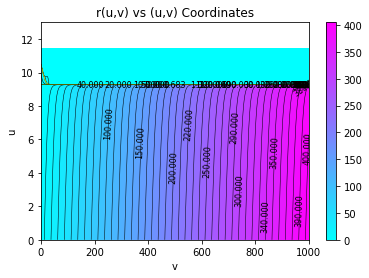

In [15]:
plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(rnpf),cmap=plt.cm.cool,vmin=0.0,vmax=np.nanmax(rnpf))#np.nanmax(rnpf[:,:,-1]))#np.nanmax(rnpf[:,:,-1]))# norm=LogNorm(vmin=0.6, vmax=.8))#

plt.xlim(0,vmax)
plt.ylim(0,umax)
#plt.xlim(0,5)
#plt.ylim(9.45378,9.45379)


plot4=plt.contour(vrange,urange,rnpf, levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot5=plt.contour(vrange,urange,rnpf, [rminus],linewidths=0.6,colors='yellow',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange,urange,rnpf, [rplus],linewidths=0.6,colors='red',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange,urange,rnpf, [rcosm],linewidths=0.6,colors='green',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, levels, inline=0, inline_spacing=0, fmt='%1.3f',rightside_up=True, fontsize=8)
if solveaffine==True:
    CHorizon=plt.plot(CH.list,urange[-1][int(uEH*Nu*Elist[-1]):],color='g')
#sample3=plt.plot(vrange[-1],drdvnplistscal)

plt.xlabel('v')
plt.ylabel('u')


plt.colorbar(plot1)
plt.title('r(u,v) vs (u,v) Coordinates')
#plt.grid()
plt.savefig('r_0_lines.png',dpi=300)
plt.show()

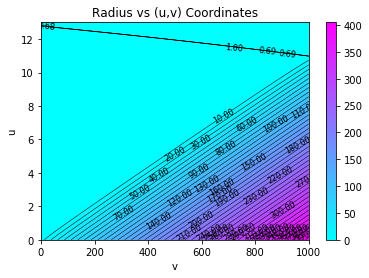

In [16]:
plot1=plt.imshow(rnpf,cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
#plot1=plt.contourf(rnpf,levels,cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot4=plt.contour(rnpf, levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, levels,  inline=0, inline_spacing=0, fmt='%1.2f',rightside_up=True,fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.xlim()
plt.colorbar(plot1)
plt.title('Radius vs (u,v) Coordinates')
#plt.savefig('Test1-2.png',dpi=300)
plt.show()

In [17]:
stop = timeit.default_timer()

In [18]:
acttime=stop - start

numpoints=Nu*Nv



print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

exttime=format((acttime-predtime)/60,'.2f')

print("Took "+str(exttime)+" more minutes")

886.3067149865283 seconds
14.771778583108805 minutes
0.24619630971848008 hours
18780000 points
21189.05304726869 points per second
Took 5.10 more minutes


In [19]:
print(signpf[:,:])

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.33350203e-04   4.57214518e-04 ...,   8.34549252e-03
    8.34549312e-03   8.34549372e-03]
 [  0.00000000e+00   4.74731927e-04   9.30174689e-04 ...,   1.69339357e-02
    1.69339369e-02   1.69339381e-02]
 ..., 
 [  0.00000000e+00  -5.89259631e+00  -6.64001529e+00 ...,  -6.49084761e+02
   -6.49233144e+02  -6.49381544e+02]
 [  0.00000000e+00  -6.51863888e+00  -7.28207800e+00 ...,  -6.49706006e+02
   -6.49854368e+02  -6.50002748e+02]
 [  0.00000000e+00  -7.33702767e+00  -8.12391178e+00 ...,  -6.50516439e+02
   -6.50664768e+02  -6.50813115e+02]]


In [20]:
print(dsigunp)

[[  0.00000000e+00              nan              nan ...,              nan
               nan              nan]
 [ -0.00000000e+00   5.83375507e-04   1.72641180e-03 ...,   4.17274611e-02
    4.17274641e-02   4.17274671e-02]
 [ -0.00000000e+00   6.08511507e-04   1.80082094e-03 ...,   4.33020879e-02
    4.33020910e-02   4.33020940e-02]
 ..., 
 [  0.00000000e+00  -1.26676761e+01  -2.56256010e+01 ...,  -2.51910439e+01
   -2.51903179e+01  -2.51896099e+01]
 [ -0.00000000e+00  -1.56510642e+01  -3.17026321e+01 ...,  -3.10628119e+01
   -3.10617445e+01  -3.10607035e+01]
 [ -0.00000000e+00  -2.04597198e+01  -4.15055642e+01 ...,  -4.05225086e+01
   -4.05208218e+01  -4.05191765e+01]]


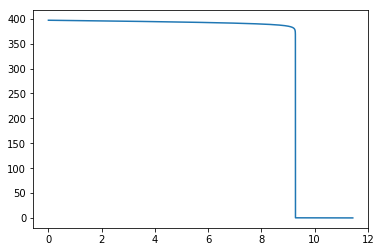

In [21]:
plt.plot(urange,rnpf[:,-100])
#plt.plot(vrange,rnpf[0,:])
plt.show()